# Machine Learning Potential Energy Surface example
See sGDML [documentation](http://www.sgdml.org/#code)

In [34]:
import numpy as np
from sgdml.predict import GDMLPredict
from sgdml.utils import io, ui
import argparse
import os
import sys
from sgdml import __version__

In [3]:
model = np.load('ethanol-aims.PBE.TS.light.tier.1-train2000-sym6.npz')
gdml = GDMLPredict(model)

r,_ = io.read_xyz('ethanol.xyz')
e,f = gdml.predict(r)

In [4]:
r


array([[-0.2161   ,  0.383454 ,  0.373037 ,  0.350325 ,  0.8106   ,
        -0.960099 , -0.0932569, -1.07753  ,  0.52357  ,  0.349465 ,
         0.810199 ,  1.39163  , -1.27296  ,  0.679169 ,  0.406791 ,
        -0.298937 ,  1.17559  , -1.78152  ,  1.07352  ,  1.51199  ,
        -0.739556 ,  1.05098  , -0.0143825, -1.32549  , -1.02219  ,
        -1.28851  ,  0.732807 ]])

In [5]:
e


array([-97191.46041679])

In [6]:
f

array([[ 20.97050004,  -6.01890852,  47.41609147,  18.73324658,
        -45.41669271, -14.88330225, -25.84944428,  19.28499601,
         -2.19671618, -27.56934791,  -9.7952442 , -60.83653668,
         -2.62430803,   0.35265037,   9.36149942,  -1.09654287,
         -8.57081708,  13.19251026,  36.09374324,  55.29134824,
          3.96433017, -26.17099472,  11.60620654,   2.17812029,
          7.51314796, -16.73353864,   1.80400349]])

## Now use Atomic Simulation Environment

In [2]:
!pip install sgdml[ase]

  Using cached ase-3.22.1-py3-none-any.whl (2.2 MB)


## Now read extended xyz data

In [3]:
from ase.io import read

In [14]:
filename = 'ethanol_ccsd_t-train.xyz'

In [36]:
filename = "syn-MVK-oxo-4000K.xyz"

In [37]:
mols = read(filename, index=':')

In [38]:
mols[0]

Atoms(symbols='C4H3O2H3', pbc=False)

In [39]:
calc = mols[0].get_calculator()

In [40]:
calc is not None

False

In [41]:
mols[0].info

{'-306.3647098134': True}

In [42]:
def read_nonstd_ext_xyz(f):
    n_atoms = None

    R, z, E, F = [], [], [], []
    for i, line in enumerate(f):
        line = line.strip()
        if not n_atoms:
            n_atoms = int(line)
            print('Number atoms per geometry: {:,}'.format(n_atoms))

        file_i, line_i = divmod(i, n_atoms + 2)

        if line_i == 1:
            try:
                e = float(line)
            except ValueError:
                pass
            else:
                E.append(e)

        cols = line.split()
        if line_i >= 2:
            R.append(list(map(float, cols[1:4])))
            if file_i == 0:  # first molecule
                z.append(io._z_str_to_z_dict[cols[0]])
            F.append(list(map(float, cols[4:7])))

        if file_i % 1000 == 0:
            sys.stdout.write('\rNumber geometries found so far: {:,}'.format(file_i))
            sys.stdout.flush()
    sys.stdout.write('\rNumber geometries found so far: {:,}'.format(file_i))
    sys.stdout.flush()
    print()

    R = np.array(R).reshape(-1, n_atoms, 3)
    z = np.array(z)
    E = None if not E else np.array(E)
    F = np.array(F).reshape(-1, n_atoms, 3)

    if F.shape[0] != R.shape[0]:
        sys.exit(
            ui.color_str('[FAIL]', fore_color=ui.RED, bold=True)
            + ' Force labels are missing from dataset or are incomplete!'
        )

    f.close()
    return (R, z, E, F)


In [43]:
with open(filename) as f:
    R, z, E, F = read_nonstd_ext_xyz(f)

name = filename
# Base variables contained in every model file.
base_vars = {
    'type': 'd',
    'code_version': __version__,
    'name': name,
    'theory': 'unknown',
    'R': R,
    'z': z,
    'F': F,
}

Number atoms per geometry: 12
Number geometries found so far: 999


In [44]:
base_vars['F_min'], base_vars['F_max'] = np.min(F.ravel()), np.max(F.ravel())
base_vars['F_mean'], base_vars['F_var'] = np.mean(F.ravel()), np.var(F.ravel())

print('Please provide a description of the length unit used in your input file, e.g. \'Ang\' or \'au\': ')
print('Note: This string will be stored in the dataset file and passed on to models files for later reference.')
base_vars['r_unit'] = 'Ang'

print('Please provide a description of the energy unit used in your input file, e.g. \'kcal/mol\' or \'eV\': ')
print('Note: This string will be stored in the dataset file and passed on to models files for later reference.')
base_vars['e_unit'] = 'kcal/mol'

if E is not None:
    base_vars['E'] = E
    base_vars['E_min'], base_vars['E_max'] = np.min(E), np.max(E)
    base_vars['E_mean'], base_vars['E_var'] = np.mean(E), np.var(E)
else:
    print(ui.color_str('[INFO]', bold=True) + ' No energy labels found in dataset.')

dataset_file_name = filename + '.npz'
base_vars['md5'] = io.dataset_md5(base_vars)
np.savez_compressed(dataset_file_name, **base_vars)
print(ui.color_str('[DONE]', fore_color=ui.GREEN, bold=True))

Please provide a description of the length unit used in your input file, e.g. 'Ang' or 'au': 
Note: This string will be stored in the dataset file and passed on to models files for later reference.
Please provide a description of the energy unit used in your input file, e.g. 'kcal/mol' or 'eV': 
Note: This string will be stored in the dataset file and passed on to models files for later reference.
[DONE]


### Calculator

In [8]:
from sgdml.intf.ase_calc import SGDMLCalculator

from ase.io import read
from ase.optimize import QuasiNewton
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution, Stationary, ZeroRotation)
from ase.md.verlet import VelocityVerlet
from ase import units
from IPython.display import HTML
from  ase.build import  molecule

### Function to create html to display molecule

In [9]:
def atoms_to_html(atoms):
    'Return the html representation the atoms object as string'

    from tempfile import NamedTemporaryFile

    with NamedTemporaryFile('r+', suffix='.html') as ntf:
        atoms.write(ntf.name, format='html')
        ntf.seek(0)
        html = ntf.read()
    return html

In [11]:
model_path = 'ethanol-aims.PBE.TS.light.tier.1-train2000-sym6.npz'
calc = SGDMLCalculator(model_path)

mol = read('ethanol.xyz')
mol.set_calculator(calc)

[WARN] Please remember to specify the proper conversion factors, if your model does not use
       'kcal/mol' and 'Ang' as units.


In [50]:
ethanol_html = atoms_to_html(mol)
HTML(ethanol_html)

In [49]:
# do a quick geometry relaxation
qn = QuasiNewton(mol)
qn.run(1e-4, 100)

                Step[ FC]     Time          Energy          fmax
BFGSLineSearch:    0[  0] 20:57:20    -4214.070540        5.3959
BFGSLineSearch:    1[  2] 20:57:20    -4214.581003        3.3624
BFGSLineSearch:    2[  4] 20:57:21    -4214.820229        2.7413
BFGSLineSearch:    3[  6] 20:57:21    -4215.079685        1.1698
BFGSLineSearch:    4[  8] 20:57:21    -4215.156243        0.9178
BFGSLineSearch:    5[ 10] 20:57:21    -4215.200981        0.7243
BFGSLineSearch:    6[ 12] 20:57:21    -4215.235723        0.5901
BFGSLineSearch:    7[ 14] 20:57:21    -4215.261799        0.6091
BFGSLineSearch:    8[ 16] 20:57:21    -4215.270879        0.5386
BFGSLineSearch:    9[ 17] 20:57:21    -4215.281794        0.4116
BFGSLineSearch:   10[ 19] 20:57:21    -4215.284509        0.2042
BFGSLineSearch:   11[ 20] 20:57:21    -4215.288114        0.1619
BFGSLineSearch:   12[ 22] 20:57:21    -4215.288789        0.1212
BFGSLineSearch:   13[ 24] 20:57:21    -4215.290373        0.1075
BFGSLineSearch:   14[ 26]

True

### Now display optimized structure

In [13]:
mol.get_chemical_symbols()

['C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H']

In [61]:
mol.get_all_distances()

array([[0.        , 1.51758622, 1.39521498, 1.10664395, 1.10664323,
        2.16480082, 2.16246053, 2.16480284, 2.46227034],
       [1.51758622, 0.        , 2.26155164, 2.1631559 , 2.16315068,
        1.0991375 , 1.09940672, 1.09913468, 3.54704883],
       [1.39521498, 2.26155164, 0.        , 2.09986187, 2.0998624 ,
        2.51243138, 3.24357749, 2.51243969, 1.29      ],
       [1.10664395, 2.1631559 , 2.09986187, 0.        , 1.78578272,
        3.0813838 , 2.49928769, 2.51279248, 2.8980128 ],
       [1.10664323, 2.16315068, 2.0998624 , 1.78578272, 0.        ,
        2.51278629, 2.49927823, 3.0813802 , 2.89801438],
       [2.16480082, 1.0991375 , 2.51243138, 3.0813838 , 2.51278629,
        0.        , 1.78339811, 1.78118228, 3.73457667],
       [2.16246053, 1.09940672, 3.24357749, 2.49928769, 2.49927823,
        1.78339811, 0.        , 1.78339437, 4.49554326],
       [2.16480284, 1.09913468, 2.51243969, 2.51279248, 3.0813802 ,
        1.78118228, 1.78339437, 0.        , 3.7345868 ],


In [70]:
mol.get_distance(2,8) # O-H distance

1.290000000000006

In [24]:
mol.get_potential_energy()

array([-4214.62058776])

In [28]:
mol.set_distance(2,8,1.7) # O-H distance

In [29]:
mol.get_potential_energy()

array([-4210.59518789])

In [112]:
import numpy as np
en = np.array([])
dist =  np.array([])
for r in np.arange(0.8,4.0,0.01):
    mol.set_distance(2,8,r) # O-H distance
    dist = np.append(dist,mol.get_distance(2,8))
    en = np.append(en,mol.get_potential_energy())

In [113]:
en = en - min(en) # Remove minimum energy offset

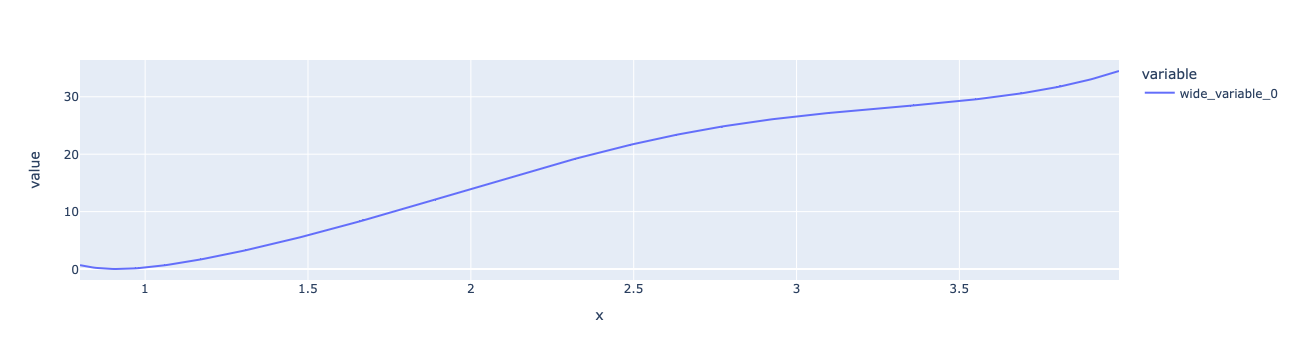

In [114]:
import plotly.express as px

fig = px.line(x=dist, y=[en])

fig.show()

In [111]:
mol.get_angle(1,2,8)

1.509794181492236

In [84]:
mol.set_angle(1,2,8, 20)
mol.set_distance(2,8, 0.97) # O-H distance

In [94]:
ena = np.array([])
ang = np.array([])
for a in np.arange(100,180,1):
    mol.set_angle(1,2,8,a) # O-H distance
    ang = np.append(ang,mol.get_angle(1,2,8))
    ena = np.append(ena,mol.get_potential_energy())

In [95]:
ena = ena - min(ena) # Remove minimum energy offset

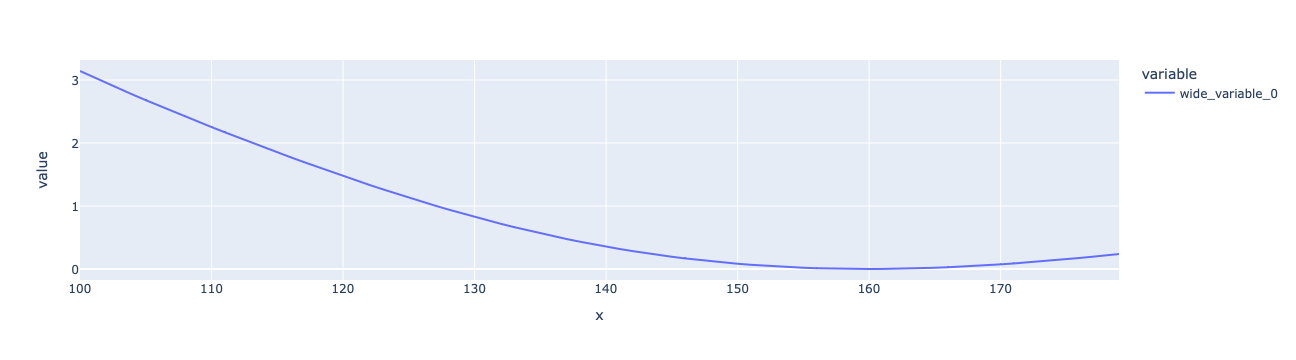

In [96]:
fig = px.line(x=ang, y=[ena])

fig.show()

In [97]:
max(ena)

3.1428264728037902

## Now scan both bond and angle

In [37]:
from ase.visualize import view

In [98]:
from ase.io import write
write('molecule.png', mol)

### 3D Plot concept
Need grid of data

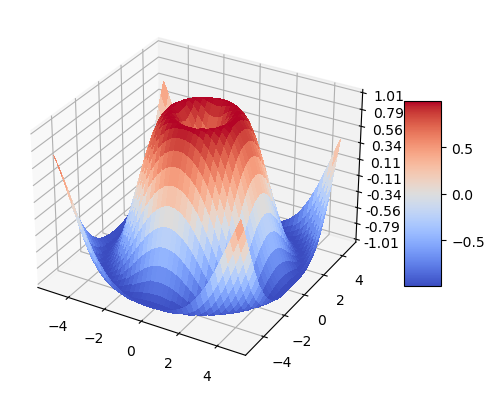

In [46]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [47]:
from mpl_toolkits.mplot3d.axes3d import get_test_data

In [48]:
X, Y, Z = get_test_data(0.05)

In [50]:
Y

array([[-30. , -30. , -30. , ..., -30. , -30. , -30. ],
       [-29.5, -29.5, -29.5, ..., -29.5, -29.5, -29.5],
       [-29. , -29. , -29. , ..., -29. , -29. , -29. ],
       ...,
       [ 28.5,  28.5,  28.5, ...,  28.5,  28.5,  28.5],
       [ 29. ,  29. ,  29. , ...,  29. ,  29. ,  29. ],
       [ 29.5,  29.5,  29.5, ...,  29.5,  29.5,  29.5]])

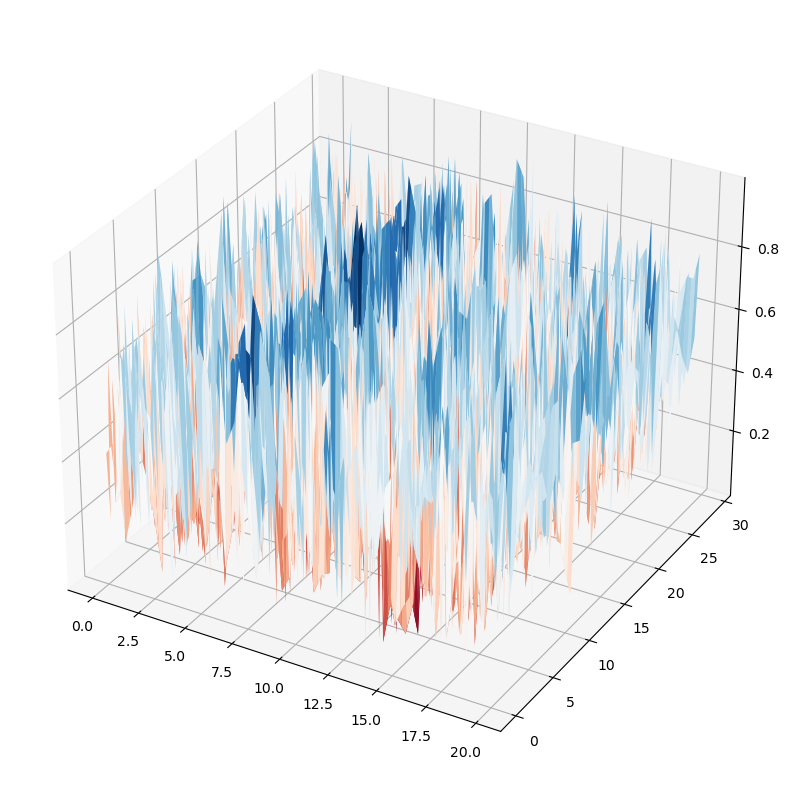

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

vel=np.random.random((21,30))
#grid old
x=np.arange(0,21,1)
y=np.arange(0,30,1)
grid_old=(x,y)

#grid new
# the limits of the interpolated x and y val have to be less than the original grid
x_new=np.arange(0.1,19.9,0.1)
y_new=np.arange(0.1,28.9,0.1)
grid_new = np.meshgrid(x_new, y_new)
grid_flattened = np.transpose(np.array([k.flatten() for k in grid_new]))

#Interpolation onto a finer grid
grid_interpol = RegularGridInterpolator(grid_old,vel,method='linear')
vel_interpol = grid_interpol(grid_flattened)

#Unflatten the interpolated velocities and store into a new variable.
index=0
vel_new=np.zeros((len(x_new),len(y_new)))
for i in  range(len(x_new)):
    for j in range(len(y_new)):
        vel_new[i,j] =vel_interpol[index]
        index+=1

fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
surf=ax.plot_surface(grid_new[0],grid_new[1],vel_new.T, cmap="RdBu") 
fig.set_size_inches(10,10) 
plt.show()

In [52]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.interpolate
from mpl_toolkits.mplot3d import Axes3D

x = np.random.random(10)
y = np.random.random(10)
z = np.random.random(10)

spline = sp.interpolate.Rbf(x,y,z,function='thin-plate')

xi = np.linspace(x.min(), x.max(), 50)
yi = np.linspace(y.min(), y.max(), 50)
xi, yi = np.meshgrid(xi, yi)

zi = spline(xi,yi)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(xi,yi,zi)
plt.show()

<Figure size 640x480 with 0 Axes>